In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
# setup
TRAIN_PATH = "../input/house-prices-advanced-regression-techniques/train.csv"
TEST_PATH = "../input/house-prices-advanced-regression-techniques/test.csv"
SUBMISSION_PATH = "../input/house-prices-advanced-regression-techniques/sample_submission.csv"

OUTPUT_PATH = "../output/kaggle/working/submission.csv"

In [3]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
sample_submission_df = pd.read_csv(SUBMISSION_PATH)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
sample_submission_df.head(5)

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


### Approach
1. First, lets create a basic LinearRegression Model using few features like Bedroom, Bathroom and SqFt
2. We will take that neg RMSE as the baseline evaluation metric
3. Then we will perform some feature engineering
4. We will use more complex models
5. Perform model hyper parameter tuning

In [6]:
train_df[["FullBath"]].value_counts()

FullBath
2           768
1           650
3            33
0             9
dtype: int64

In [7]:
train_df[["LotArea"]].value_counts()

LotArea
7200       25
9600       24
6000       17
9000       14
10800      14
           ..
8930        1
8935        1
8944        1
8960        1
215245      1
Length: 1073, dtype: int64

<AxesSubplot:ylabel='Frequency'>

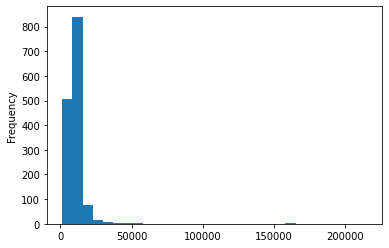

In [8]:
train_df["LotArea"].plot.hist(bins = 30)

<AxesSubplot:ylabel='Frequency'>

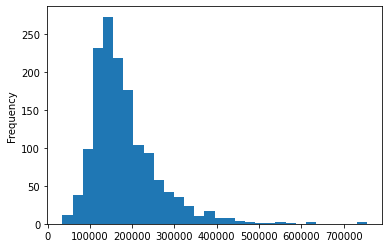

In [9]:
train_df["SalePrice"].plot.hist(bins = 30)

In [10]:
# since the saleprice target column is right skewed lets apply log transformation on it
# this will help us with the rmse error for the outliers

#train_df["SalePrice"] = np.log(train_df["SalePrice"])

In [11]:
#train_df["SalePrice"].plot.hist()

In [12]:
# perform minmax scaler
def perform_minmaxscaler(df, col):
    min_value = df[col].min()
    max_value = df[col].max()
    df[col] = (df[col] - min_value) / (max_value - min_value)
    return df

# perform cross validation
from sklearn.model_selection import cross_val_score
def perform_cross_validation(model, features, target, train):
    X = train[features]
    Y = train[target]
    scores = cross_val_score(model, X, Y, cv=10, scoring = 'neg_root_mean_squared_error')
    mean_score = np.mean(scores)
    return mean_score
    

In [13]:
train_df[["BedroomAbvGr"]].value_counts()

BedroomAbvGr
3               804
2               358
4               213
1                50
5                21
6                 7
0                 6
8                 1
dtype: int64

In [14]:
initial_features = ["BedroomAbvGr", "LotArea", "FullBath"]
target = "SalePrice"
for col in initial_features:
    train_df = perform_minmaxscaler(train_df, col)

In [15]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
#model.fit(train_df[initial_features], train_df[target])
score = perform_cross_validation(model, initial_features, target, train_df)
print(score)

-64322.25591931094


In [16]:
def model_training(train_df, features, target):
    model = LinearRegression()
    X = train_df[features]
    Y = train_df[target]
    model.fit(X, Y)
    return model
    
def generate_predictions(model, test_df, features):
    for col in initial_features:
        test_df = perform_minmaxscaler(test_df, col)
    predictions = model.predict(test_df[features])
    return predictions

In [17]:
model = model_training(train_df, initial_features, target)

In [18]:
model.coef_

array([-45124.60711927, 341672.38957573, 240706.85495637])

In [19]:
predictions = generate_predictions(model, test_df, initial_features)

In [20]:
predictions[0:10]

array([164848.92456241, 173720.74641404, 231189.11924538, 207316.05476786,
       184016.27494539, 207452.40144971, 194933.29702484, 197548.67428588,
       155887.22901867, 144880.3332471 ])

In [21]:
ids = test_df["Id"]
submission = pd.DataFrame(
    {
        "Id": ids,
        "SalePrice": predictions
    }
)

submission.to_csv("submission.csv", index=False)

In [22]:
test_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,0.184147,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,0.232124,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,0.224197,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,0.154326,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,0.064121,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
